In [ ]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot
from scipy.sparse import csr_matrix

from utils import *

In [ ]:
# Load two real signals

sr = 44100
duration = 3
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


## Using ffts

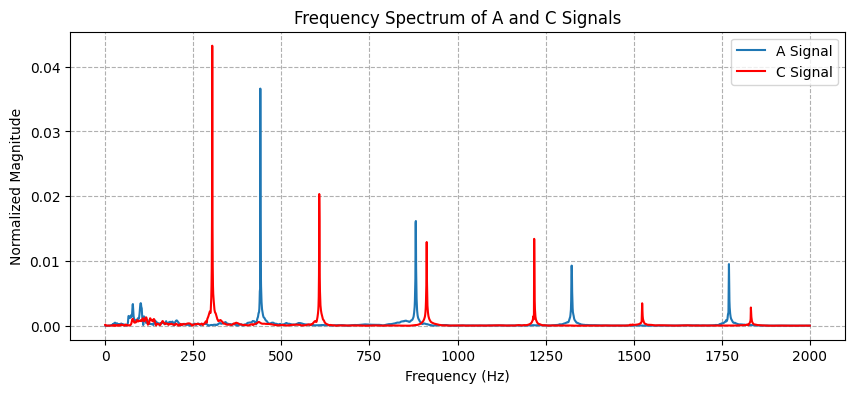

In [ ]:

A_fft = np.fft.rfft(A_signal)
C_fft = np.fft.fft(C_signal)
fft_frequency = np.fft.fftfreq(len(A_signal), d=1/sr)
fft_frequency = fft_frequency[:len(fft_frequency) // 2]
n = len(fft_frequency)

# Take the magnitude of the FFT and normalize it
A_fft_magnitude = np.abs(A_fft)[:n]
A_fft_magnitude /= np.sum(A_fft_magnitude)
C_fft_magnitude = np.abs(C_fft)[:n]
C_fft_magnitude /= np.sum(C_fft_magnitude)


max_frequency_index = 2000 # in Hz, for plotting 
index = np.argmax(fft_frequency > max_frequency_index)

plt.figure(figsize=[10, 4])

# Use line plots for a cleaner look
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title('Frequency Spectrum of A and C Signals')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.show()

In [ ]:
def emd_optimal_transport(frequency, a1, a2, alpha=0.5): # can i get rid of frequency?

    emd_plan = ot.emd_1d(frequency, frequency, a1, a2)

    emd_plan = csr_matrix(emd_plan)
    emd_interpolation = np.zeros(len(frequency))
    row, col = emd_plan.nonzero()
    for i, j in zip(row, col):
        index = get_frequency(i, j, alpha=alpha, method='int')
        emd_interpolation[index] += emd_plan[i, j]
    
    return emd_interpolation

In [ ]:
# Optimal transport

alpha = 0.5

# Quantile method 

fft_quantile_interpolation = quantile_optimal_transport(A_fft_magnitude, C_fft_magnitude, alpha=alpha)

# EMD 

fft_emd_plan = ot.emd_1d(fft_frequency, fft_frequency, A_fft_magnitude, C_fft_magnitude)

fft_emd_plan = csr_matrix(fft_emd_plan)
fft_emd_interpolation = np.zeros(len(fft_frequency))
row, col = fft_emd_plan.nonzero()
for i, j in zip(row, col):
    index = get_frequency(i, j, alpha=alpha, method='int')
    fft_emd_interpolation[index] += fft_emd_plan[i, j]


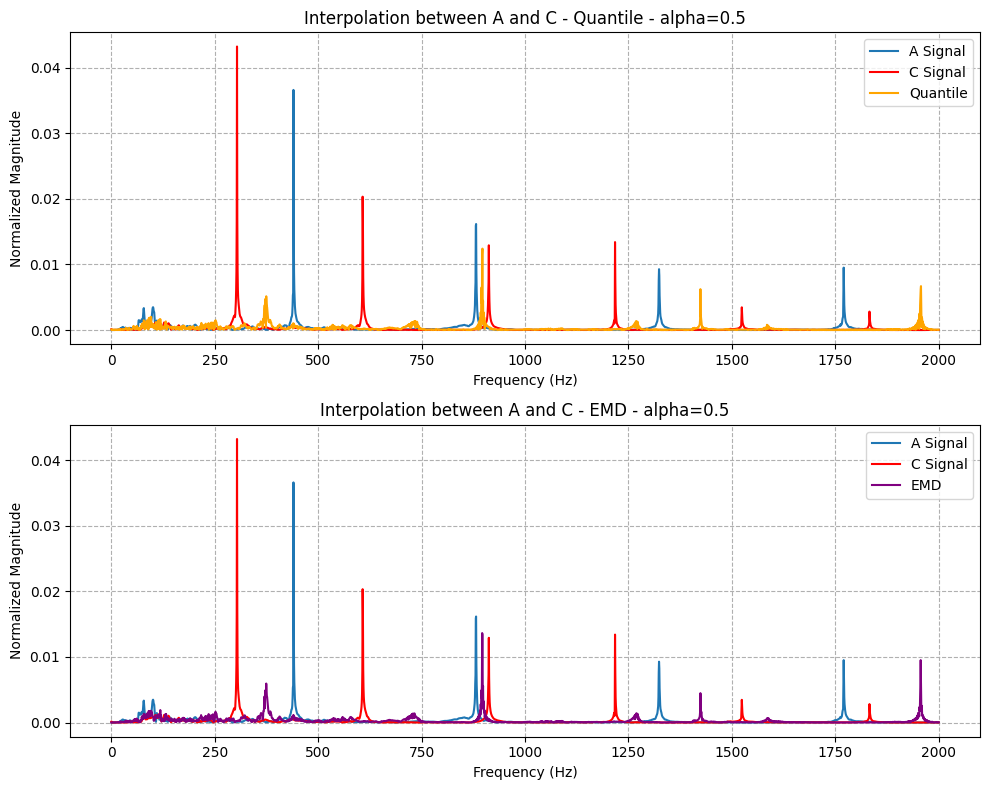

In [ ]:
max_frequency_index = 2000 # in Hz, for plotting 
index = np.argmax(fft_frequency > max_frequency_index)

plt.figure(figsize=[10, 8])  # Increase figure size to accommodate both subplots

# First subplot for A, C, and quantile interpolation
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
plt.plot(fft_frequency[:index], fft_quantile_interpolation[:index], label='Quantile', color="orange")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title(f'Interpolation between A and C - Quantile - alpha={alpha}')
plt.grid(True, which="both", ls="--")
plt.legend()

# Second subplot for A, C, and EMD interpolation
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
plt.plot(fft_frequency[:index], fft_emd_interpolation[:index], label='EMD', color="purple")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title(f'Interpolation between A and C - EMD - alpha={alpha}')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()  # Adjust the layout so the plots are neatly arranged
plt.show()

In [ ]:
fft_quantile_inversed = np.fft.ifft(fft_quantile_interpolation)
fft_emd_inversed = np.fft.ifft(fft_emd_interpolation)

audio_widgets = []

title = widgets.Label(f'A')
audio_player = IPython.display.Audio(data=A_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C')
audio_player = IPython.display.Audio(data=C_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Quantile interpolation - alpha={alpha}')
audio_player = IPython.display.Audio(data=fft_quantile_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation - alpha={alpha}')
audio_player = IPython.display.Audio(data=fft_emd_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

## Using STFTs

In [ ]:
from math import log2, ceil

window_size = 20 # ms
window_size_samples = window_size * 1e-3 * sr
n_fft = 2 ** ceil(log2(window_size_samples))
A_stft = librosa.stft(A_signal, n_fft=n_fft)
C_stft = librosa.stft(C_signal, n_fft=n_fft)

stft_frequency = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

In [ ]:
# Optimal transport

alpha = 0.5
n_frames = A_stft.shape[1]

stft_quantile_interpolation = np.zeros_like(A_stft)
stft_emd_interpolation = np.zeros_like(A_stft)

for frame in range(n_frames):

    A_frame, A_frame_relative_amplitude = normalized_frame(A_stft, frame)
    C_frame, C_frame_relative_amplitude = normalized_frame(C_stft, frame)

    interpolated_frame_relative_amplitude = (1-alpha) * A_frame_relative_amplitude + alpha * C_frame_relative_amplitude

    # Quantile method
     
    stft_quantile_interpolation[:, frame] = quantile_optimal_transport(A_frame, C_frame, alpha=alpha) * interpolated_frame_relative_amplitude

    # EMD 

    stft_emd_plan = ot.emd_1d(stft_frequency, stft_frequency, A_frame, C_frame)
    stft_emd_plan = csr_matrix(stft_emd_plan)
    row, col = stft_emd_plan.nonzero()
    for i, j in zip(row, col):
        index = get_frequency(i, j, alpha=alpha, method='int')
        stft_emd_interpolation[index][frame] += stft_emd_plan[i, j]
    stft_emd_interpolation[:, frame] *= interpolated_frame_relative_amplitude
        

/var/folders/3q/fky9tlbn3_qfz7hw6cxpgdv40000gp/T/ipykernel_5392/1310150362.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),


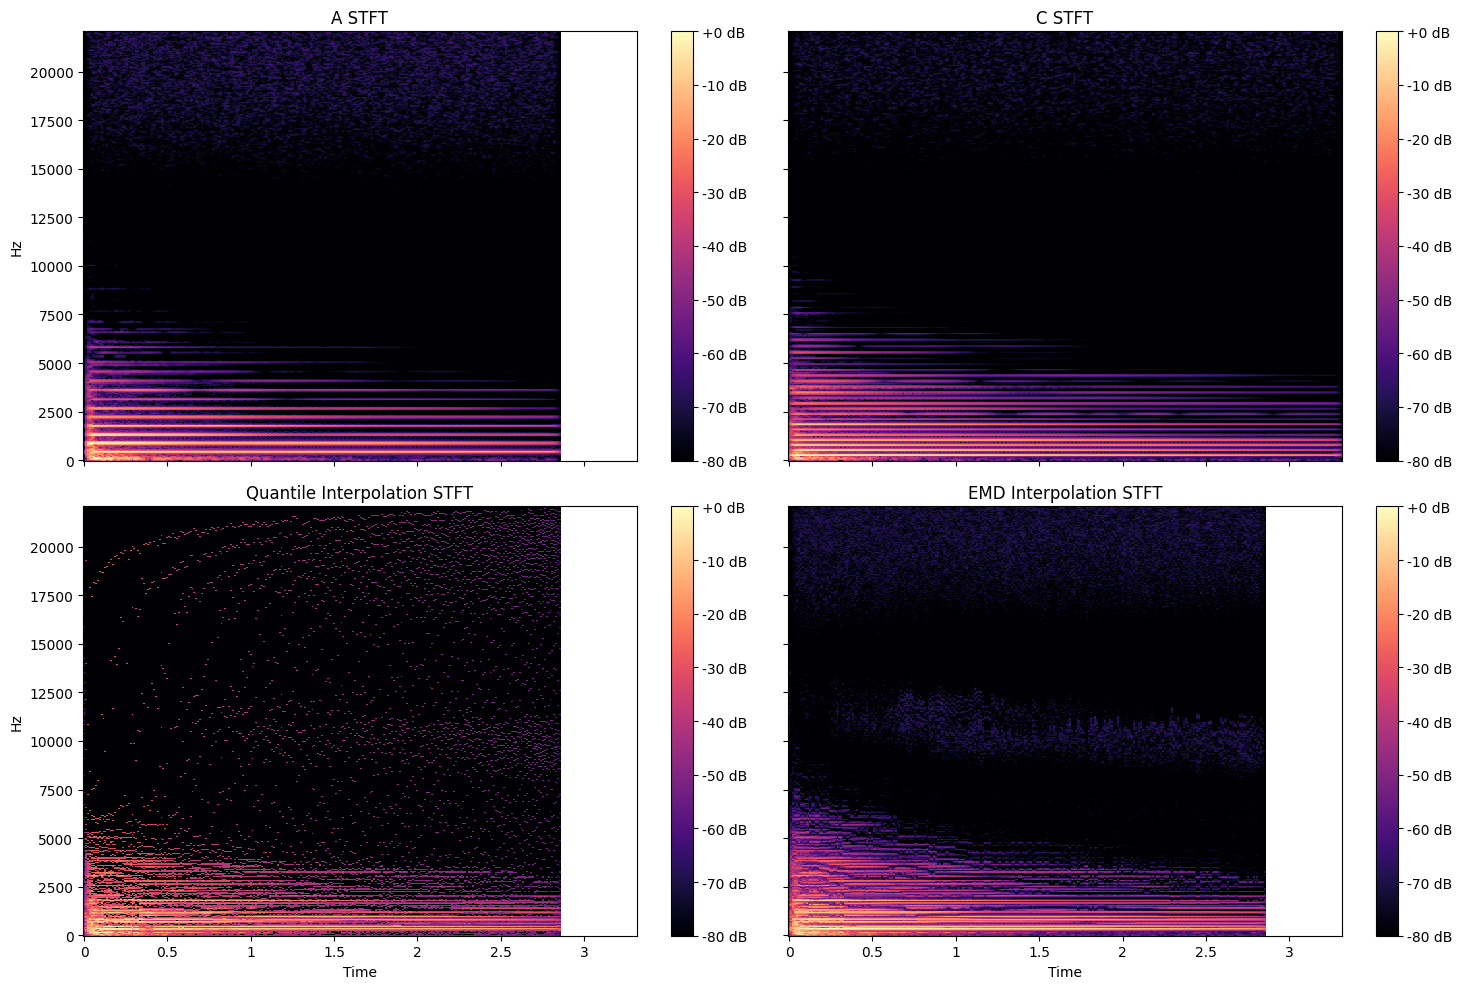

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
titles = ['A STFT', 'C STFT', 'Quantile Interpolation STFT', 'EMD Interpolation STFT']
spectrograms = [A_stft, C_stft, stft_quantile_interpolation, stft_emd_interpolation]

for ax, spectrogram, title in zip(axs.flatten(), spectrograms, titles):
    img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                   ax=ax,
                                   x_axis='time',
                                   y_axis='hz',
                                   sr=sr)
    ax.set_title(title)
    ax.label_outer()
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [ ]:
stft_quantile_inversed = librosa.griffinlim(stft_quantile_interpolation, n_iter=100)
stft_emd_inversed = librosa.griffinlim(stft_emd_interpolation, n_iter=100)

audio_widgets = []

title = widgets.Label(f'A')
audio_player = IPython.display.Audio(data=A_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C')
audio_player = IPython.display.Audio(data=C_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Quantile interpolation - alpha={alpha}')
audio_player = IPython.display.Audio(data=stft_quantile_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation - alpha={alpha}')
audio_player = IPython.display.Audio(data=stft_emd_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid